In [38]:
import warnings
warnings.filterwarnings('ignore')

# Repairing bad pixels

In this notebook we try to automatically detect and repair [bad pixels](https://photographylife.com/dead-vs-stuck-vs-hot-pixels) in a RAW image. The [sample image](http://eol.jsc.nasa.gov/SearchPhotos/photo.pl?mission=ISS030&roll=E&frame=122539) used here can be found on NASA's [Gateway to Astronaut Photography of Earth](http://eol.jsc.nasa.gov) website.

## Imports
For displaying images in this notebook we first import [matplotlib](http://matplotlib.org/).

In [39]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 15, 25
from matplotlib.pyplot import imshow

The image processing is done with [rawpy](https://pypi.python.org/pypi/rawpy) which is imported below.

In [40]:
import rawpy
import rawpy.enhance

## Detecting bad pixels

Most bad pixels can be spotted by looking for unusual dots or crosses in the processed image, often in bright red, green, or blue color as shown below.

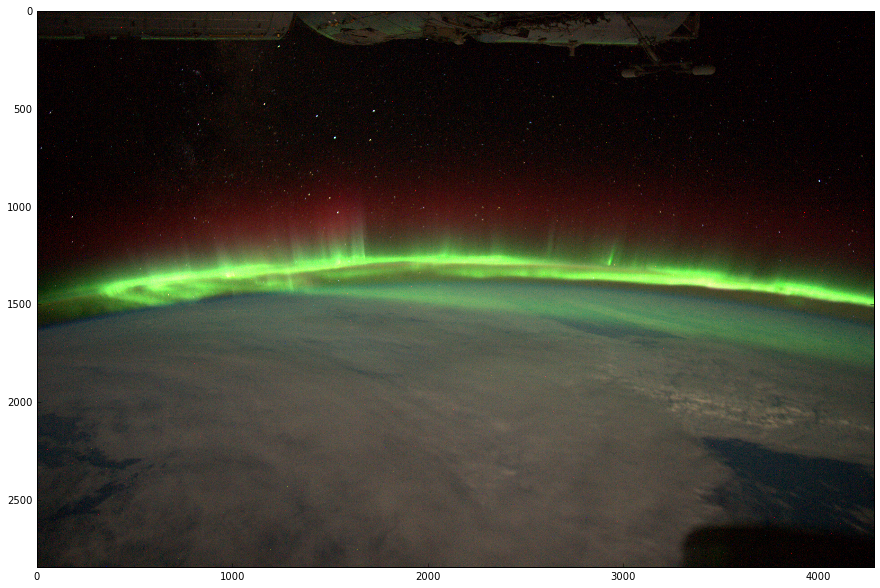

In [41]:
raw = rawpy.imread('../images/ISS030-E-122539.nef')
rgb = raw.postprocess(user_flip=3) # rotate by 180° because RAW image is upside down
imshow(rgb)

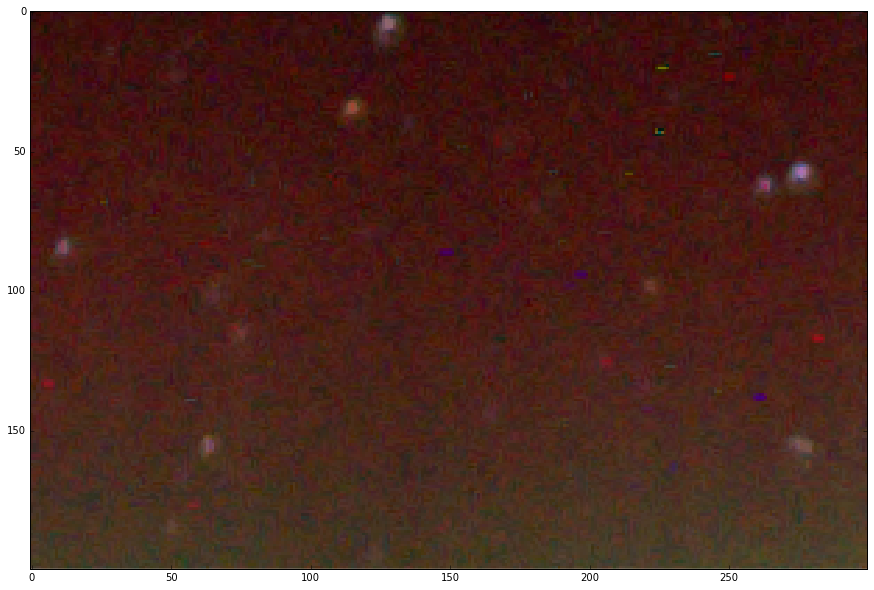

In [42]:
imshow(rgb[950:1150,1700:2000], interpolation='none')

The automated bad pixel detection of rawpy operates on the unprocessed [Bayer mosaic](https://en.wikipedia.org/wiki/Bayer_filter). Just for fun, let's look at this mosaic.

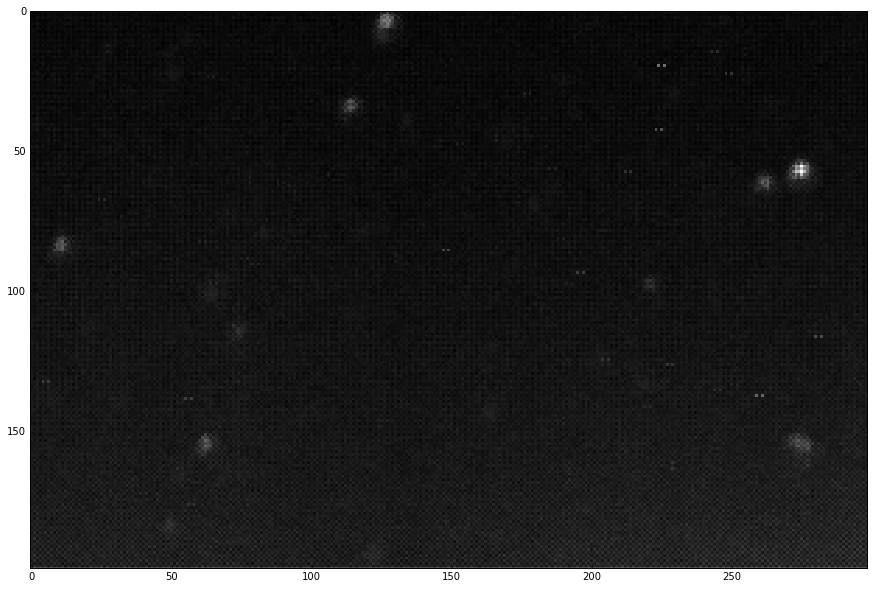

In [43]:
raw_img_rotated = raw.raw_image_visible[::-1,::-1]
imshow(raw_img_rotated[951:1150,1701:2000], cmap='gray', interpolation='none')

The algorithm implemented in rawpy detects bad pixels per-channel by comparing each pixel to the median of its 3x3 neighborhood and marking it as bad if the difference between both values exceeds a certain threshold. The assumption is that neighboring pixels should have a very similar brightness, otherwise they are probably defective.

In [44]:
bad_pixels = rawpy.enhance.find_bad_pixels(['../images/ISS030-E-122539.nef'])
print(bad_pixels)
print(len(bad_pixels))

imread: 0.29901719093322754 s
threshold: 27
median: 0.27901601791381836 s
median: 0.36802101135253906 s
median: 0.37502145767211914 s
median: 0.2950170040130615 s
badpixel candidates: 1.5170869827270508 s
[[   0    0]
 [   0    2]
 [   0    6]
 ..., 
 [2843 4277]
 [2843 4279]
 [2843 4281]]
4979270


The result is an array of y/x positions of the detected bad pixels. Nearly 5 million pixels, around 40% of the image, were identified as bad pixels. Before thinking about why this number is way too high let's correct the found pixels and see if the image improves.

In [45]:
rawpy.enhance.repair_bad_pixels(raw, bad_pixels) # modifies the RAW image in-place!

repairing 4979270 bad pixels
median: 0.2720153331756592 s
median: 0.37002110481262207 s
median: 0.3720214366912842 s
median: 0.29701685905456543 s
badpixel repair: 2.2101263999938965 s


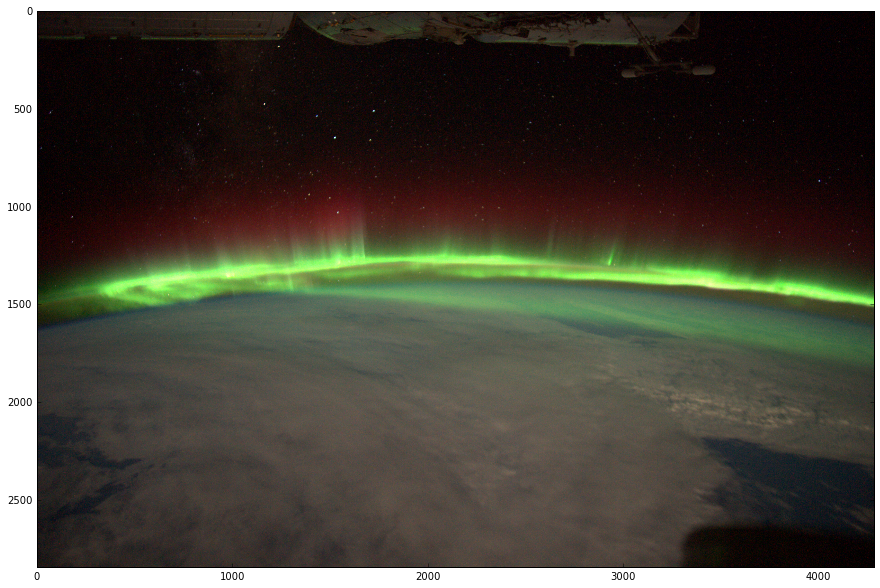

In [46]:
rgb = raw.postprocess(user_flip=3)
imshow(rgb)

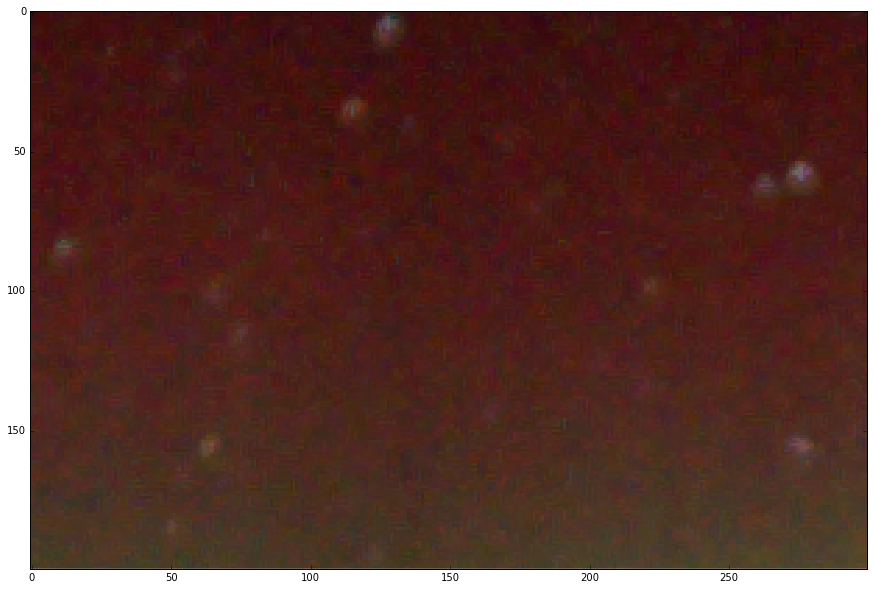

In [47]:
imshow(rgb[950:1150,1700:2000], interpolation='none')

At first sight, the image seems to be fine now. No bad pixels can be easily spotted anymore. However, when looking at the stars in the zoomed image then lots of weird artifacts can be seen compared to the original image. This is because way too many intact pixels have been falsily identified as bad pixels. The automated detection algorithm is rather simple and it is in general not easy to reliably detect bad pixels just from a single photograph, especially when the image contains a considerable amount of noise.

A way out of this is to use multiple photographs taken around the same time, ideally of different scenes. Then the bad pixel candidates of each image can be cross-checked against the candidates of the other images, keeping only those candidates  which appear in nearly all images. rawpy supports this method and uses a default acceptance threshold of 90%.

In [48]:
bad_pixels = rawpy.enhance.find_bad_pixels(['../images/ISS030-E-' + str(n) + '.nef' for n in range(122539,122639,10)])
print(len(bad_pixels))

imread: 0.29701685905456543 s
threshold: 27
median: 0.2690153121948242 s
median: 0.3720211982727051 s
median: 0.3710212707519531 s
median: 0.3000173568725586 s
badpixel candidates: 1.5100862979888916 s
imread: 0.29901719093322754 s
threshold: 27
median: 0.26601505279541016 s
median: 0.37302112579345703 s
median: 0.3720211982727051 s
median: 0.30101728439331055 s
badpixel candidates: 1.5150866508483887 s
imread: 0.29701685905456543 s
threshold: 27
median: 0.2720155715942383 s
median: 0.37002134323120117 s
median: 0.37302160263061523 s
median: 0.2910168170928955 s
badpixel candidates: 1.5060863494873047 s
imread: 0.30301713943481445 s
threshold: 27
median: 0.27301549911499023 s
median: 0.37702155113220215 s
median: 0.3760213851928711 s
median: 0.30301713943481445 s
badpixel candidates: 1.5310876369476318 s
imread: 0.2980170249938965 s
threshold: 27
median: 0.28101587295532227 s
median: 0.38802218437194824 s
median: 0.3830220699310303 s
median: 0.30301737785339355 s
badpixel candidates: 1

Using ten images, only ~80000 bad pixels were identified, which is around 0.7% of all pixels. This number seems a lot more realistic. Let's see if the stars in the zoomed image look better now.

In [49]:
raw = rawpy.imread('../images/ISS030-E-122539.nef')
rgb_original = raw.postprocess(user_flip=3)
rawpy.enhance.repair_bad_pixels(raw, bad_pixels) # modifies the RAW image in-place!

repairing 81709 bad pixels
median: 0.2720155715942383 s
median: 0.36802101135253906 s
median: 0.36802101135253906 s
median: 0.29901719093322754 s
badpixel repair: 1.3340764045715332 s


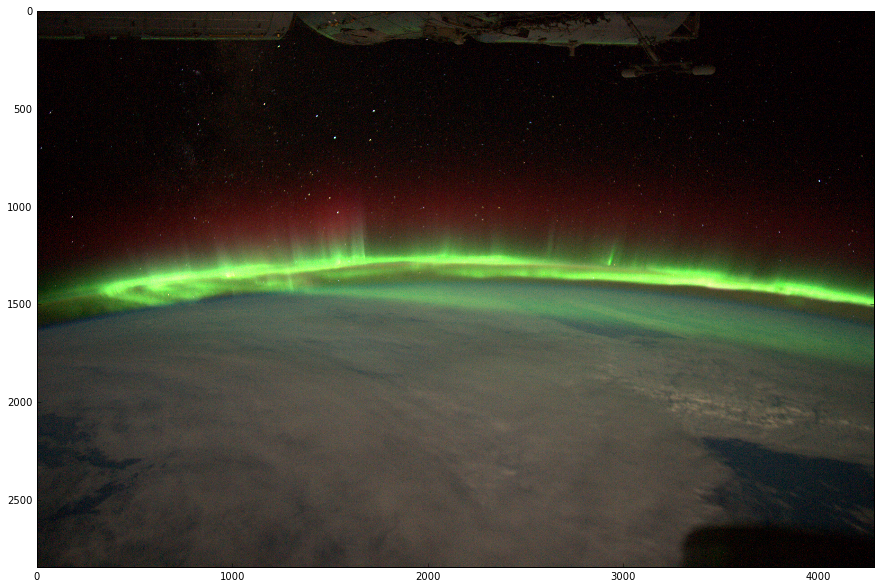

In [50]:
rgb = raw.postprocess(user_flip=3)
imshow(rgb)

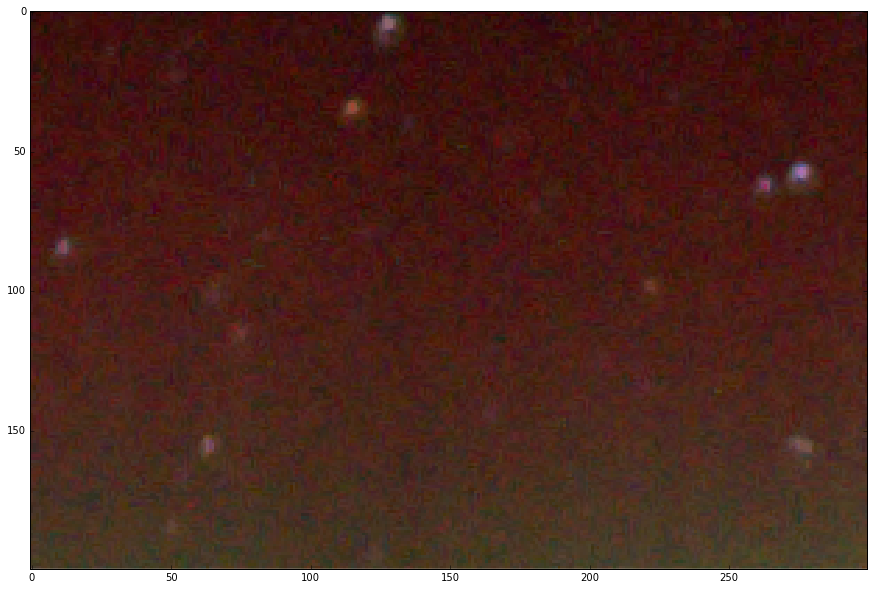

In [51]:
imshow(rgb[950:1150,1700:2000], interpolation='none')

For direct comparison, here again the unrepaired image:

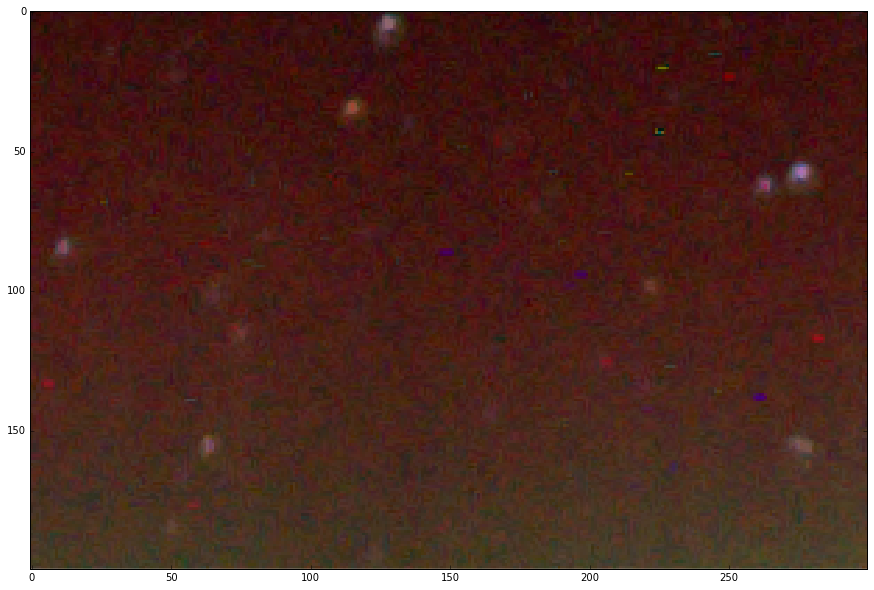

In [52]:
imshow(rgb_original[950:1150,1700:2000], interpolation='none')